<h1> Tasa de Desempleo de EEUU </h1>
<hr>

Para el desarrollo de este proyecto, se realizó la descarga de la base de datos. Se tomó desde Enero de 1948 hasta Diciembre de 2019. Aunque el assement decía que era hasta el 2017, se tomaron 2 años de más para ver que tan buenas serían las predicciones acorde a los modelos que se implementarán. A continuación realizamos la carga de los modulos implementados para este análisis:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import datetime as dt
import re

Cargadas las librerías a utilizar, se procede a cargar la información que se requiere:

In [2]:
df = pd.read_csv("UNRATE.csv")
df["DATE"] = pd.DatetimeIndex(df["DATE"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d")))
df["MES"]  = df.reset_index()["DATE"].apply(lambda x: x.month)
df["ANIO"]  = df.reset_index()["DATE"].apply(lambda x: x.year)
df.set_index("DATE", inplace=True)
df

,UNRATE,MES,ANIO
DATE,,,
1948-01-01,3.4,1,1948
1948-02-01,3.8,2,1948
1948-03-01,4.0,3,1948
1948-04-01,3.9,4,1948
1948-05-01,3.5,5,1948
...,...,...,...
2019-08-01,3.6,8,2019
2019-09-01,3.5,9,2019
2019-10-01,3.6,10,2019


A continuación se realiza el gráfico para los datos que se van a manejar:

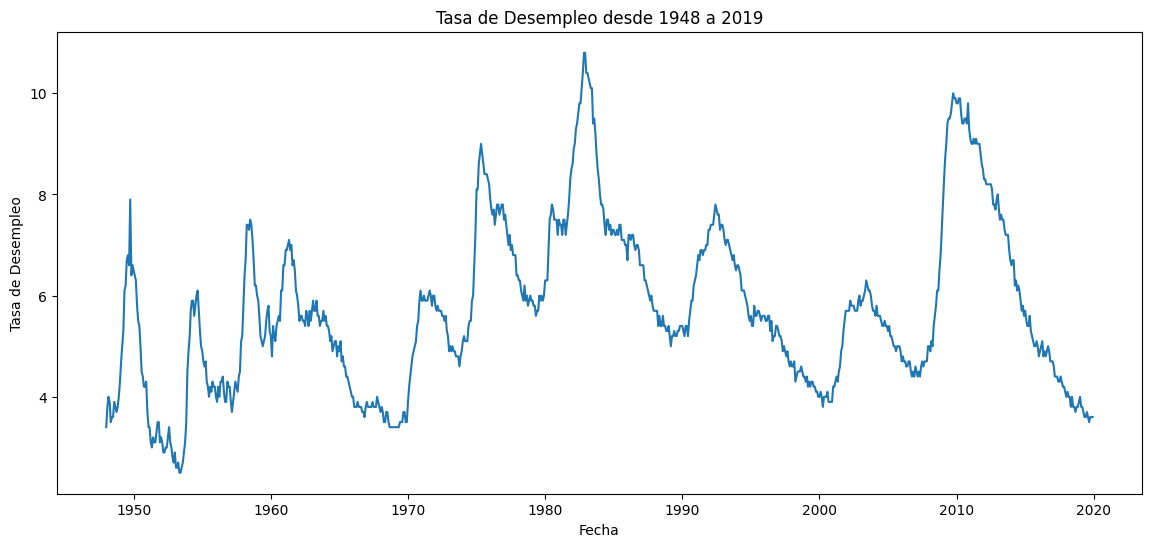

In [3]:
fig, ax = plt.subplots(figsize = (14,6))

ax.plot(df.reset_index()["DATE"],df["UNRATE"])
ax.set_title("Tasa de Desempleo desde 1948 a 2019")
ax.set_xlabel("Fecha")
ax.set_ylabel("Tasa de Desempleo")
plt.show()

Ahora realizamos un gráfico para ver el comportamiento mensual

In [4]:
df[["UNRATE"]]

,UNRATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
...,...
2019-08-01,3.6
2019-09-01,3.5
2019-10-01,3.6


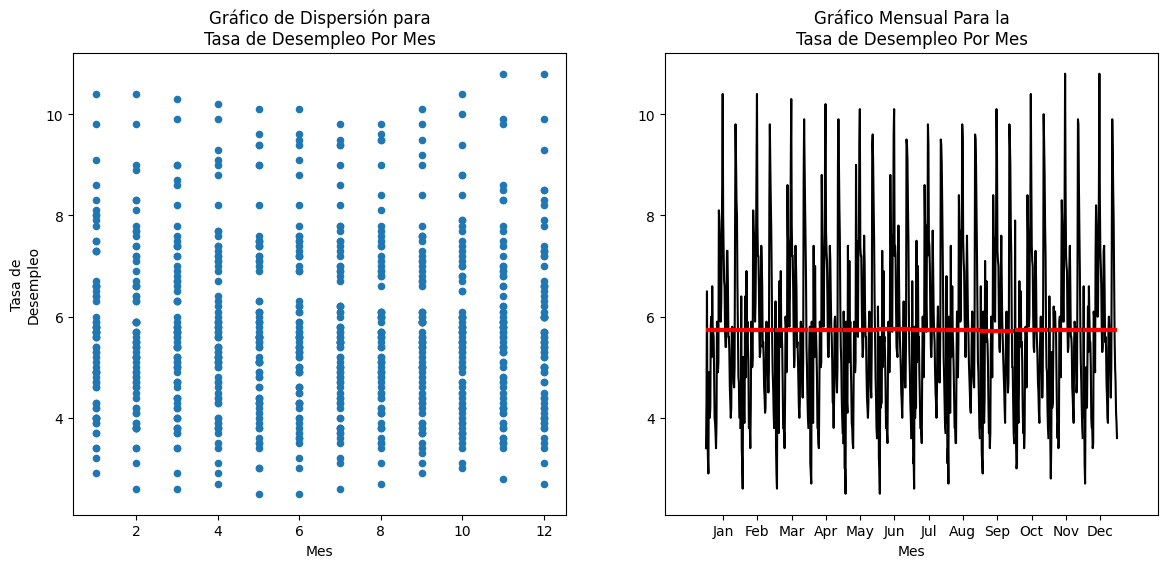

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
(
    df.
    groupby(["MES", "ANIO"]).
    agg(
        UNRATE = ("UNRATE", "mean")
    ).
    reset_index().
    plot(x = "MES", y = "UNRATE", kind="scatter", ax = ax[0])
)

ax[0].set_title("Gráfico de Dispersión para\nTasa de Desempleo Por Mes")
ax[0].set_xlabel("Mes")
ax[0].set_ylabel("Tasa de\nDesempleo")

ax[1].set_title("Gráfico Mensual Para la\nTasa de Desempleo Por Mes")
ax[1].set_xlabel("Mes")
ax[1].set_ylabel("Tasa de\nDesempleo")

sm.graphics.tsa.month_plot(df[["UNRATE"]], ax = ax[1])
plt.show()

In [6]:
md = seasonal_decompose(df[["UNRATE"]], model="multiplicative", period=12, extrapolate_trend='freq')

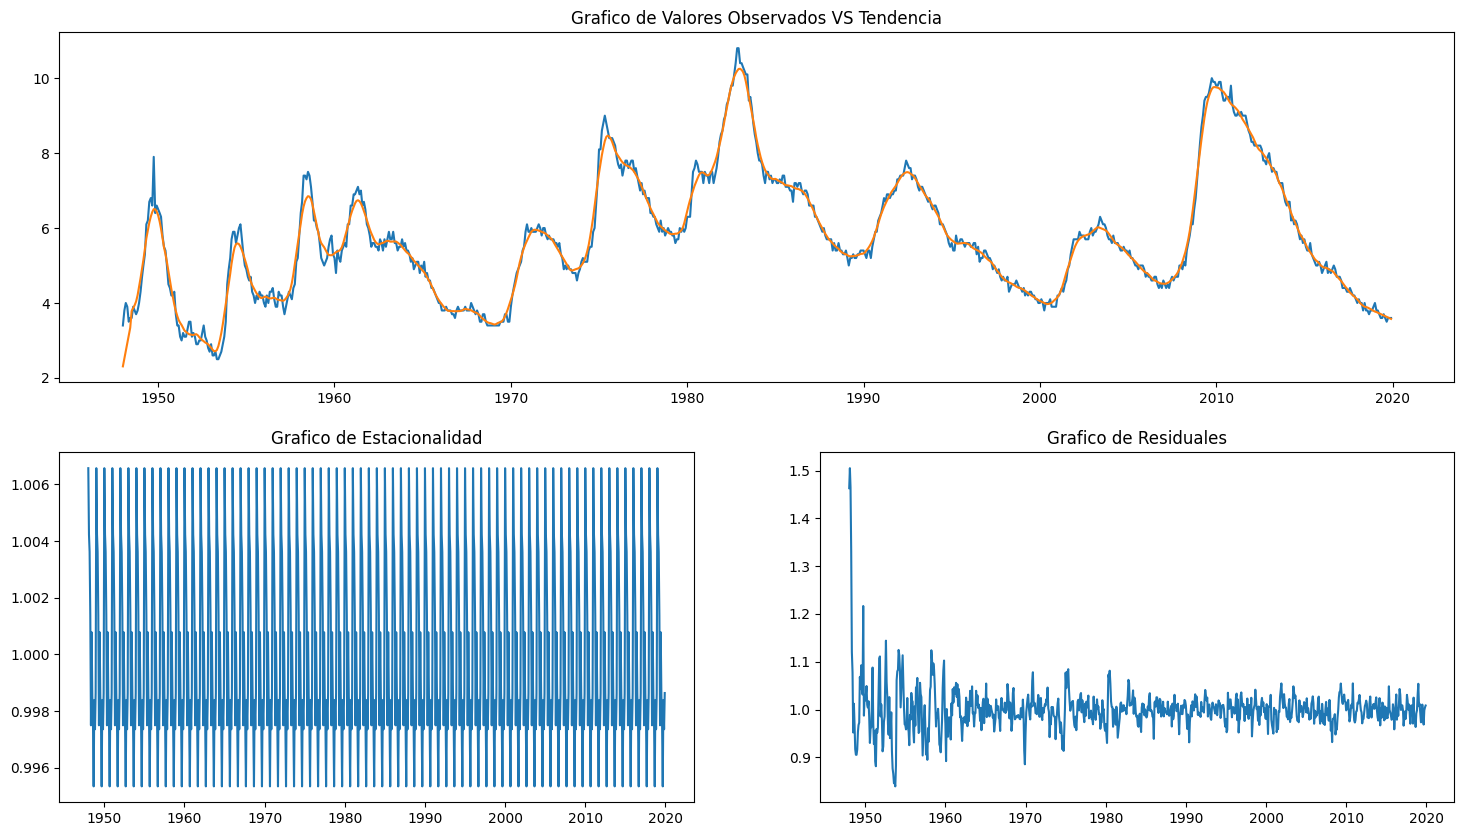

In [7]:
mosaic = [["A", "A"],
          ["B", "C"]]
fig, ax = plt.subplot_mosaic(mosaic, figsize = (18,10))

ax["A"].plot(md.observed)
ax["A"].plot(md.trend)
ax["B"].plot(md.seasonal)
ax["C"].plot(md.resid)

ax["A"].set_title("Grafico de Valores Observados VS Tendencia")
ax["B"].set_title("Grafico de Estacionalidad")
ax["C"].set_title("Grafico de Residuales")

plt.show()